# Single multiplications, multiple layers

I'd like to look at the single-task network again but with SVD now.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 689334534
set_all_seeds(seed)
print(seed)

2538015667


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y = generate_Y(n_samples)
X = generate_X(Y, eps)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 2]) torch.Size([10000, 1])


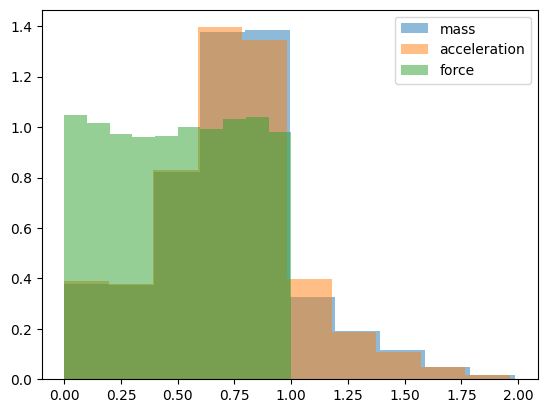

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=2, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/JBremner/miniconda3/envs/physics-mi/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8000, 1])) that is different to the input size (torch.Size([8000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/JBremner/miniconda3/envs/physics-mi/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([2000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Results

In [8]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

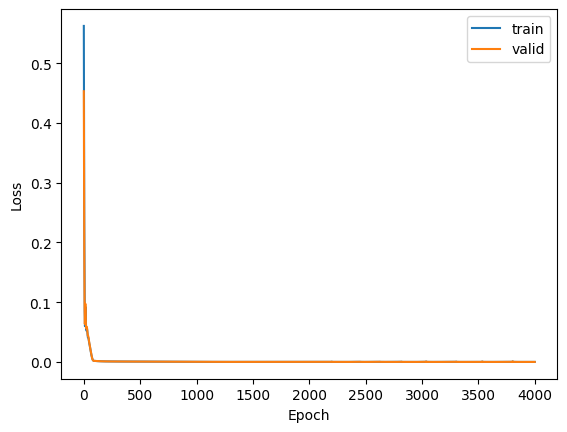

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 1))

In [11]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(2.1408e-05)

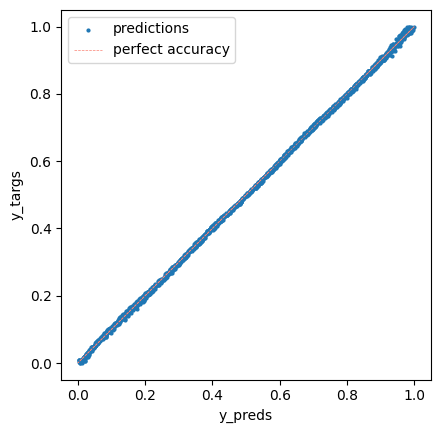

In [12]:
plot_results(y_preds[:, 0], y_targs[:, 0])

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

I would like to look at the weight matrix of the second linear layer.

In [14]:
W = model.state_dict()["layers.1.linear.weight"]
W.shape

torch.Size([16, 16])

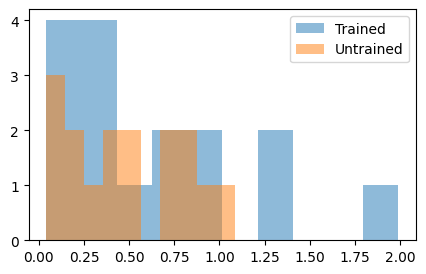

In [15]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(torch.svd(W).S.detach().numpy(), alpha=0.5, label="Trained")
ax.hist(
    torch.svd(Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2).state_dict()["layers.1.linear.weight"])
    .S.detach()
    .numpy(),
    alpha=0.5,
    label="Untrained",
)

_ = ax.legend()

In [16]:
torch.svd(W).S

tensor([1.9910, 1.2997, 1.2135, 0.9109, 0.8602, 0.7750, 0.6787, 0.5753, 0.3973,
        0.3632, 0.2944, 0.2565, 0.2040, 0.1352, 0.0961, 0.0409])

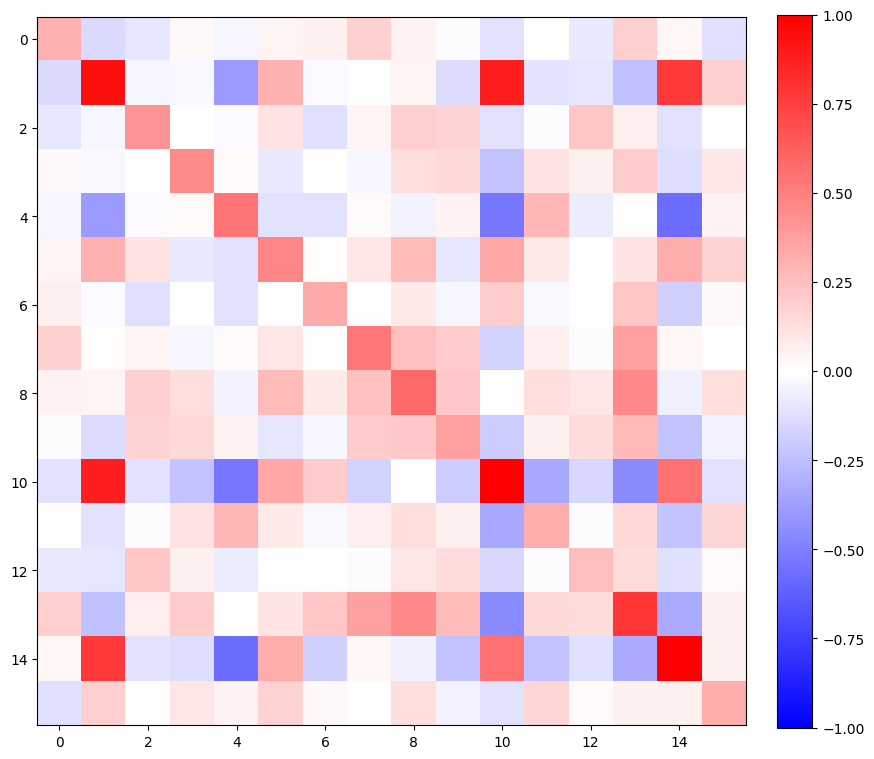

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(torch.matmul(W, W.T).numpy(), cmap="bwr", vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

A similar story here to the multi-task case. I don't _feel_ like these SVDs are really telling us much about task independence tbh so I might need to change course.